In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import diffmah
from diffmah import mah_halopop, DEFAULT_MAH_PARAMS
from diffmah.utils import get_cholesky_from_params
import jax
from jax import grad
from jax import random
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm
from jax import jit
import corner

/var/folders/gw/k3g4y13d0_38hyq_g18hp1s80000gn/T/ipykernel_20129/2485339737.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Define Fiducial model

In [2]:
mu_true = jnp.array([jnp.log10(2), 3, 2])
cov_true = jnp.array([[0.2,  0,    0],
       [0.04, 0.5,  0],
       [0.06, 0.08, 0.2]])

In [3]:
cov_true

Array([[0.2 , 0.  , 0.  ],
       [0.04, 0.5 , 0.  ],
       [0.06, 0.08, 0.2 ]], dtype=float32)

In [4]:
L = jnp.linalg.cholesky(cov_true)

In [5]:
L @ L.T

Array([[0.19999999, 0.02      , 0.03      ],
       [0.02      , 0.5       , 0.04      ],
       [0.03      , 0.04      , 0.19999999]], dtype=float32)

In [6]:
@jit
def logpdf_cholesky(x, mu, L):
    diff = x - mu
    z = jnp.linalg.solve(L, diff)
    quad = jnp.dot(z, z)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))
    log_norm = 1.5 * jnp.log(2 * jnp.pi) + log_det
    return -0.5 * quad - log_norm

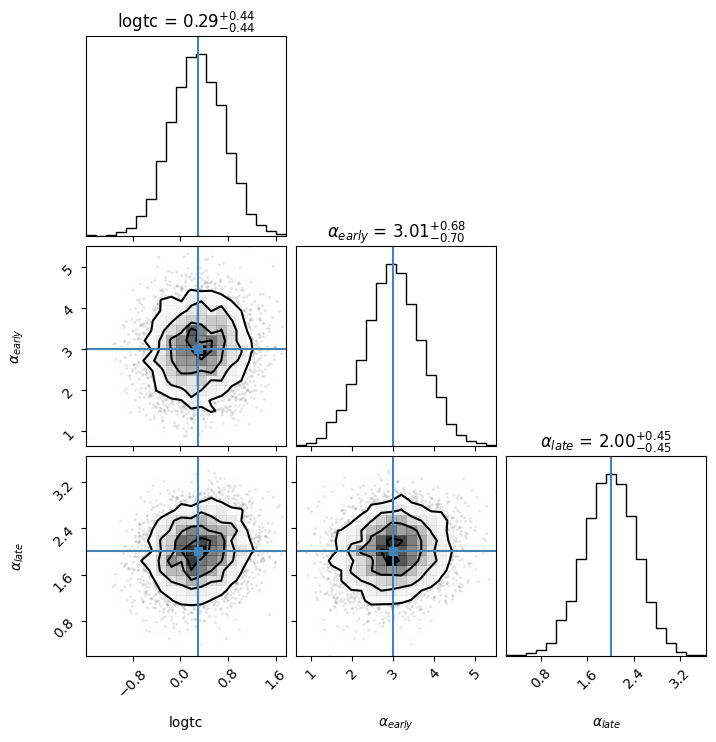

In [7]:
def sample_gaussian_cholesky(mu, cov, key, N=5000):
    L = jnp.linalg.cholesky(cov)
    z = jax.random.normal(key, shape=(N, 3))
    return mu + z @ L.T


# Sample
key = jax.random.PRNGKey(42)
samples = sample_gaussian_cholesky(mu_true, cov_true, key)

# Convert to NumPy for plotting
samples_np = np.array(samples)

# Plot corner plot
figure = corner.corner(samples_np, labels=["logtc", "$\u03b1_{early}$", "$\u03b1_{late}$"],
                       truths=mu_true, show_titles=True, title_fmt=".2f")

plt.show()

In [8]:
def diffmahpop_model(psi, tarr):
    samples = sample_gaussian_cholesky(psi["mu"], psi["cov"], key, N=5000)
    logtc_draws = samples[:,0]
    early_draws = samples[:,1]
    late_draws  =  samples[:,2]

    ZZ = jnp.zeros(len(logtc_draws))
    logt0 = jnp.log10(tarr[-1])
    
    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    
    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_draws, early_draws, late_draws, t_peak_arr))
    dmhdt, log_mahs = mah_halopop(mah_params, tarr, logt0)

    return log_mahs, jnp.mean(log_mahs, axis=0)

In [9]:
def mse(mean_mhalo_true: jnp.ndarray, mean_mhalo_pred: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mean_mhalo_true - mean_mhalo_pred, 2)) + 

In [10]:
def mseloss(psi, model, tarr, mean_mhalo_true):
    _, mean_mhalo_pred = model(psi, tarr)
    return mse(mean_mhalo_true, mean_mhalo_pred)

In [11]:
dmseloss = grad(mseloss)

In [12]:
def model_optimization_loop(psi, model, loss, dloss, tarr, mean_mhalo_true, 
                            n_steps=10000, step_size=0.001):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(mu=psi["mu"], cov=psi["cov"]),
                      model, tarr, mean_mhalo_true)
        
        psi["mu"]   = psi["mu"]   -  step_size*grads["mu"]
        psi["cov"]  = psi["cov"]  -  step_size*grads["cov"]

        losses.append(loss(dict(mu=psi["mu"], cov=psi["cov"]), 
                           model, tarr, mean_mhalo_true))

    return losses, psi

#### Fiducial model

In [13]:
tarr = jnp.linspace(0.5, 13.8, 100)
log_mahs_true, mean_mhalo_true = diffmahpop_model(dict(mu=mu_true, cov=cov_true), tarr)


#### Random initial guess

In [14]:
logtc_mean_rand = np.random.uniform(jnp.log10(1),jnp.log10(3))
logtc_var_rand = np.random.uniform(0.1,0.3)

early_mean_rand = np.random.uniform(0.1,10)
early_var_rand = np.random.uniform(0.05,0.4)

late_mean_rand = np.random.uniform(0.1,5)
late_var_rand = np.random.uniform(0.05,0.4)

off_diag_rand = [np.random.uniform(0.01,0.1), np.random.uniform(0.01,0.1), np.random.uniform(0.01,0.1)]
mu_rand = jnp.array([logtc_mean_rand, early_mean_rand, late_mean_rand])
cov_rand = jnp.array([[logtc_var_rand,  0,    0],
                      [off_diag_rand[0], early_var_rand,  0],
                      [off_diag_rand[1], off_diag_rand[2], late_var_rand]])

log_mahs_guess, mean_mhalo_guess = diffmahpop_model(dict(mu=mu_rand, cov=cov_rand), tarr)


In [15]:
cov_rand

Array([[0.2501546 , 0.        , 0.        ],
       [0.08793637, 0.16217165, 0.        ],
       [0.05322311, 0.02469702, 0.09694634]], dtype=float32)

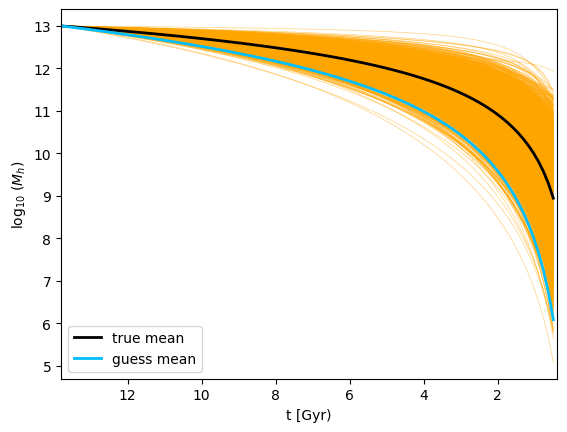

In [16]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    __=ax.plot(tarr, mah, color='orange', alpha=0.5, lw=0.5)
    i+=1
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')



__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

In [17]:
losses, psi = model_optimization_loop(dict(mu=mu_rand, cov=cov_rand),
                                      diffmahpop_model, mseloss, dmseloss, tarr, mean_mhalo_true)

  0%|          | 0/10000 [00:00<?, ?it/s]

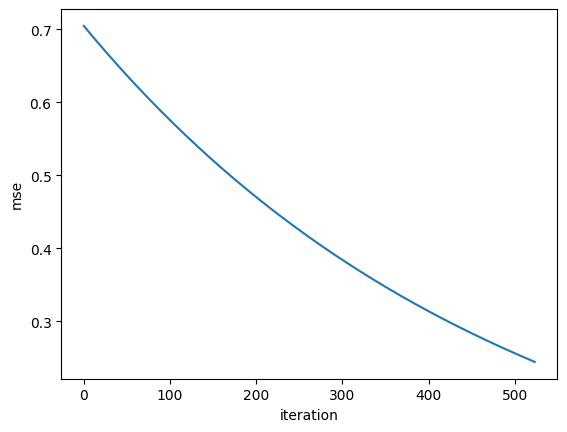

In [18]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

#### Fitted model

In [19]:
log_mahs_fit, mean_mhalo_fit = diffmahpop_model(dict(mu=psi["mu"], cov=psi["cov"]), tarr)

In [20]:
mean_mhalo_fit

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

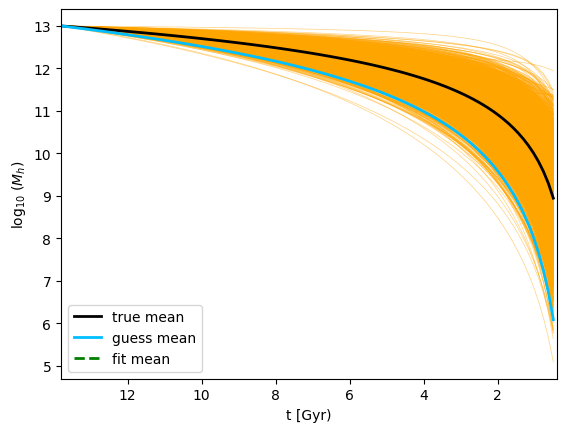

In [21]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    __=ax.plot(tarr, mah, color='orange', alpha=0.5, lw=0.5)
    i+=1
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
__=ax.plot(tarr, mean_mhalo_fit, c='g', ls ='--', lw=2, label='fit mean')




__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()